<a href="https://colab.research.google.com/github/GYIKOO/UCIMLHackathon21/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
import numpy as np

from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from keras.preprocessing.sequence import pad_sequences
from pathlib import Path
import matplotlib.pyplot as plt

In [22]:
# Config
save_model = Path('bertmodel.h5')

seed_val = 1 # random seed for training

MAX_LEN = 32
batch_size = 8

epochs = 1
checkpoint = 2

n_jobs = 2 # num of labels

class_weight = torch.FloatTensor([1,5])

In [5]:
df = pd.read_csv('/content/covid_lies.csv')
df = df.assign(related=[1]*len(df))
df.head()

,misconception_id,misconception,tweet,tweet_id,label,related
0,3,Coronavirus is genetically engineered.,How the COVID-19 outbreak is changing global p...,1233965490948591616,na,1
1,30,Blowing conch shells destroys coronavirus pote...,Getting coronavirus and then coughing on peopl...,1233907923765559296,na,1
2,57,Swans and dolphins swimming in Venice canals f...,Disturbing letter about life in COVID-19 ward ...,1233911842910720000,na,1
3,22,Cocaine cures coronavirus.,How to prevent corona virus?🤔 Use cowdung cake...,1233947734094290944,na,1
4,32,Observing janata curfew will result in the red...,This is concerning - They must self-insure for...,1233937085297332224,na,1


In [ ]:
df.head(10)

,misconception_id,misconception,tweet,tweet_id,label,related
0,3,Coronavirus is genetically engineered.,How the COVID-19 outbreak is changing global p...,1233965490948591616,na,1
1,30,Blowing conch shells destroys coronavirus pote...,Getting coronavirus and then coughing on peopl...,1233907923765559296,na,1
2,57,Swans and dolphins swimming in Venice canals f...,Disturbing letter about life in COVID-19 ward ...,1233911842910720000,na,1
3,22,Cocaine cures coronavirus.,How to prevent corona virus?🤔 Use cowdung cake...,1233947734094290944,na,1
4,32,Observing janata curfew will result in the red...,This is concerning - They must self-insure for...,1233937085297332224,na,1
5,25,Holy communion cannot be the cause of the spre...,@USERNAME @USERNAME coronavirus and illegals ;...,1233955845756653568,na,1
6,61,Lions were freed to keep people off the street...,@USERNAME @USERNAME Not surprised with dem &am...,1233917889557692416,na,1
7,3,Coronavirus is genetically engineered.,@USERNAME @USERNAME @USERNAME No it's not. Cor...,1233952635725778944,na,1
8,40,Cannabis protects against COVID-19.,UN health agency warns against coronavirus COV...,1233940738439815168,na,1
9,50,It is safe for individuals infected with COVID...,"“Most people (not elderly, no underlying healt...",1233920123183828992,na,1


# Sample

The table of first 20 misconceptions.

In [6]:
miscon_df = df[['misconception_id','misconception']].drop_duplicates(subset='misconception_id').sort_values(by='misconception_id').reset_index(drop=True)
mini_mdf = miscon_df[:20].reset_index(drop=True)
mini_mdf

,misconception_id,misconception
0,1,A person can tell if they have coronavirus or ...
1,2,Drinking large amounts of water will protect a...
2,3,Coronavirus is genetically engineered.
3,4,Dean Koontz predicted the pandemic in his 1981...
4,5,The first person infected is a researcher name...
5,6,A decade-old map published by the World Popula...
6,7,Boiled ginger can cure coronavirus.
7,8,Vitamin C can prevent coronavirus circulation.
8,9,Africans are more resistant to coronavirus.
9,10,Coronavirus is caused by 5G.


The table of first 15 tweets.

In [7]:
tweets_df = df[['tweet_id','tweet']].drop_duplicates(subset='tweet').sort_values(by='tweet_id')
mini_tdf = tweets_df[:15].reset_index(drop=True)
mini_tdf = mini_tdf.assign(tweet_index = [i for i in range(1,len(mini_tdf)+1)])
mini_tdf

,tweet_id,tweet,tweet_index
0,1230000000000000000,How long does the new coronavirus remain activ...,1
1,1230000000000000000,Millimetre wave technology will kill an indivi...,2
2,1230000000000000000,How do we strengthen our immune systems to fig...,3
3,1233904797775990784,"When it comes to coronavirus, who is the most ...",4
4,1233904858601840640,#Coronavirus and China's Tax Response\n\n@USER...,5
5,1233904868076683264,How has the coronavirus impacted the classroom...,6
6,1233904883482296320,Coronavirus' cure can be found from the source...,7
7,1233904905687097344,A touch of Pontius Pilate . \n\nCoronavirus: B...,8
8,1233904929242218496,"Moderna, a biotech company who recently made i...",9
9,1233904948607365120,Bill Gates predicted a coronavirus-like outbre...,10


Connect all pairs of elements in the two tables. Mark existed relationships between misconception and tweet in original dataset as 'related'.

In [8]:
temp1 = mini_tdf.loc[mini_tdf.index.repeat(len(mini_mdf))].reset_index(drop=True)

In [9]:
full_table = temp1.assign(misconception_id = mini_mdf.misconception_id.values.tolist()*len(mini_tdf),
              misconception = mini_mdf.misconception.values.tolist()*len(mini_tdf))

In [10]:
sample = pd.merge(full_table, df,
     how = 'left',
     left_on = ['tweet_id','tweet','misconception_id','misconception'],
     right_on = ['tweet_id','tweet','misconception_id','misconception']
    ).drop(columns='label').fillna(0)
sample.related = sample.related.astype('int64')
sample.head()

,tweet_id,tweet,tweet_index,misconception_id,misconception,related
0,1230000000000000000,How long does the new coronavirus remain activ...,1,1,A person can tell if they have coronavirus or ...,0
1,1230000000000000000,How long does the new coronavirus remain activ...,1,2,Drinking large amounts of water will protect a...,0
2,1230000000000000000,How long does the new coronavirus remain activ...,1,3,Coronavirus is genetically engineered.,0
3,1230000000000000000,How long does the new coronavirus remain activ...,1,4,Dean Koontz predicted the pandemic in his 1981...,0
4,1230000000000000000,How long does the new coronavirus remain activ...,1,5,The first person infected is a researcher name...,0


In [11]:
sample.related.astype('object').describe()

count     300
unique      2
top         0
freq      288
Name: related, dtype: int64

# Words Embedding

In [12]:
def vectorize(text,MAX_LEN=MAX_LEN):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    input_ids = []
    for t in text:
        # so basically encode tokenizing , mapping sentences to thier token ids after adding special tokens.
        encoded_sent = tokenizer.encode(
            t,  # Sentence which are encoding.
            add_special_tokens=True,  # Adding special tokens '[CLS]' and '[SEP]'
        )
        input_ids.append(encoded_sent)

    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN , truncating="post", padding="post")

    attention_masks = []
    for sent in input_ids:
        # Generating attention mask for sentences.
        #   - when there is 0 present as token id we are going to set mask as 0.
        #   - we are going to set mask 1 for all non-zero positive input id.
        att_mask = [int(token_id > 0) for token_id in sent]

        attention_masks.append(att_mask)

    return attention_masks, input_ids

In [13]:
m_text = miscon_df.misconception.values
m_attention_mask, m_input_id = vectorize(m_text)

In [14]:
t_text = tweets_df.tweet.values
t_attention_mask, t_input_id = vectorize(t_text,64)

In [15]:
X_inputs = []
X_masks = []

for i in range(0,len(sample)):
  t_index = sample.tweet_index[i]-1
  inputs_temp = t_input_id[t_index].tolist().copy()
  masks_temp = t_attention_mask[t_index].copy()

  m_index = sample.misconception_id[i]-1
  inputs_temp.extend(m_input_id[m_index].tolist())
  masks_temp.extend(m_attention_mask[m_index])

  X_inputs.append(inputs_temp)
  X_masks.append(masks_temp)
X_inputs = np.array(X_inputs)

# Split Data

In [16]:
from sklearn.model_selection import train_test_split
labels = sample.related.values
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(X_inputs, labels, random_state=1, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(X_masks, labels, random_state=1, test_size=0.2)

In [17]:
# changing the numpy arrays into tensors for working on GPU.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation(test) set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Train

In [33]:
def bertpretrain(train_dataloader, validation_dataloader):
    
    if save_model.exists():
        model = torch.load(save_model)
    else:
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            config = BertConfig()
            )

    # Running the model on GPU.
    # model.cuda()

    # Running on GPU if available, otherwise on CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    optimizer = AdamW(model.parameters(),
                      lr = 2e-5,
                      eps = 1e-8
                      )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value in run_glue.py
                                                num_training_steps=total_steps)

    # Set the seed value all over the place to make this reproducible.
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Store the average loss after each epoch so we can plot them.
    loss_values = []
    accuracy_values = []

    # For each epoch...
    for epoch in range(0, epochs):

        # ========================================
        #               Training
        # ========================================
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_loss = 0

        model.train() # switch to training mode

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            outputs = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)

            # Pull the loss value out of the tuple.
            ce = torch.nn.CrossEntropyLoss(weight=class_weight)
            loss = ce(outputs[1],b_labels)
            #loss = outputs[0]

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end.
            total_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

        # ========================================
        #        Validation
        # ========================================

        print("")
        print("Running Validation...")

        t0 = time.time() # Validation start time

        # Put the model in evaluation mode
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            batch = tuple(t.to(device) for t in batch)


            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients, saving memory and
            # speeding up validation
            with torch.no_grad():
                outputs = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask)

            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy

            # Track the number of batches
            nb_eval_steps += 1

        # Report the final accuracy for this validation run.
        accuracy_values.append(eval_accuracy / nb_eval_steps)
        print("  Accuracy: {0:.2f}".format(eval_accuracy / nb_eval_steps))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))

        if epoch % checkpoint == 0:
          torch.save(model,save_model)
 

    print("Saving model...")
    torch.save(model, save_model)

    plot_acc_loss(accuracy_values,loss_values)

    print("")
    print("Training complete!")

In [19]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def plot_acc_loss(acc,loss):
    x1 = range(0, epochs)
    x2 = range(0, epochs)
    y1 = acc
    y2 = loss
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 1 ========
Training...

  Average training loss: 0.48
  Training epcoh took: 0:04:32

Running Validation...
  Accuracy: 0.97
  Validation took: 0:00:18
Saving model...


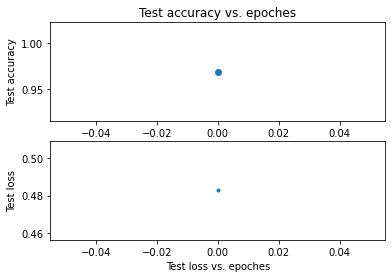


Training complete!


In [34]:
bertpretrain(train_dataloader,validation_dataloader)

# Validation

In [36]:
from sklearn.metrics import plot_roc_curve, accuracy_score, confusion_matrix, f1_score, balanced_accuracy_score, roc_auc_score

def binary_eval(model_type:str, label, prediction):
    print(model_type,'accuracy', balanced_accuracy_score(label, prediction))
    print(model_type,'forest f1',f1_score(label, prediction, average='weighted'))
    print(model_type,'roc_auc', roc_auc_score(label, prediction, average='weighted'))
    print(model_type,'confusion matrix', confusion_matrix(label, prediction))
    print('')

In [37]:
def bertpredict(model,inputs,masks):
    bert_pred = model(inputs,
                      token_type_ids=None,
                      attention_mask=masks)[0].detach().cpu().numpy()
    bertpred_class = np.argmax(bert_pred,axis=1).flatten()
    return bertpred_class

In [38]:
bert = torch.load(save_model)

result = bertpredict(bert, validation_inputs, validation_masks)

In [39]:
binary_eval('bert',validation_labels,result)

bert accuracy 0.5
bert forest f1 0.9502824858757061
bert roc_auc 0.5
bert confusion matrix [[58  0]
 [ 2  0]]

